# Research Questions

In [32]:
# Import all libraries

import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime
import shapely.geometry as sgeom
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
%matplotlib inline
from tabulate import tabulate

In [33]:
# Load the dataset

# Specify cell track statistics data location
stats_file = 'trackstats_20220601.0000_20220630.2359.nc'
# Terrain file is for plotting purpose only
terrain_file = 'KHGX_Terrain_RangeMask.nc'


# Radar location
radar_lat = 29.4719
radar_lon = -95.0787

# Output figure directory
figdir = 'Figures'
os.makedirs(figdir, exist_ok=True)

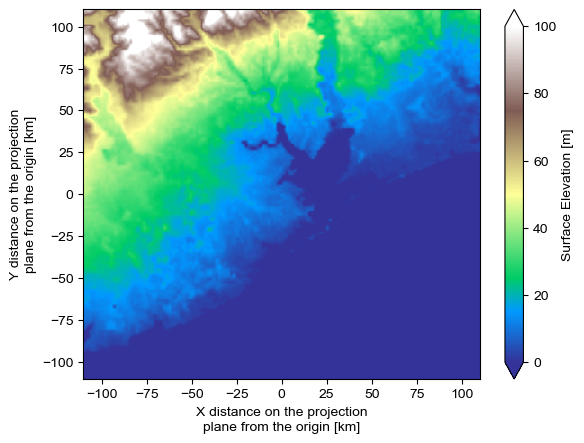

In [34]:
# Read topography file
terr = xr.open_dataset(terrain_file)
topoZ = terr['hgt']
topoLon = terr['x']
topoLat = terr['y']
topoZ.plot(vmin=0, vmax=100, cmap='terrain');

In [35]:
# Read cell tracking data
stats = xr.open_dataset(stats_file)
time_res = stats.attrs['time_resolution_hour']
pixel_radius = stats.attrs['pixel_radius_km']

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Find tracks where initiation longitude is not NaN
# These tracks are problematic and should be excluded
ind = np.where(~np.isnan(cell_lon0))[0]

# Subset the tracks
stats = stats.isel(tracks=ind).load()
ntracks = stats.dims['tracks']
print(f'Number of valid tracks: {ntracks}')
stats

c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Number of valid tracks: 3606


<xarray.Dataset>
Dimensions:                  (tracks: 3606, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 3602 3603 3604 3605
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 7 3 18 15 2 9 6 2 ... 1 4 4 3 1 2 2
    base_time                (tracks, times) datetime64[ns] 2022-06-01T00:01:...
    meanlat                  (tracks, times) float32 28.89 28.9 ... nan nan
    meanlon                  (tracks, times) float32 -95.67 -95.68 ... nan nan
    area                     (tracks, times) float32 20.5 19.0 15.25 ... nan nan
    cloudnumber              (tracks, times) float64 1.0 4.0 6.0 ... nan nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan ... 3.581e+03 nan nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... 11.0 nan nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... 5.0 nan nan
    end_merge_tracknumber    (tracks) float64 nan nan nan ... 3.581e+03 nan nan
    end_merge_timeindex      (tracks) float64 nan nan nan nan ... 13.0 nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan nan nan ... 10.0 nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Jul 10 21:16:26 2023
    startdate:             20220601.0000
    enddate:               20220630.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [36]:
# Get cell statistics variables
tracks = stats['tracks']
times = stats['times']

lifetime = stats['track_duration'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
core_area = stats['core_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['max_dbz']
eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']


## Desriptive analysis of the core area and cell area

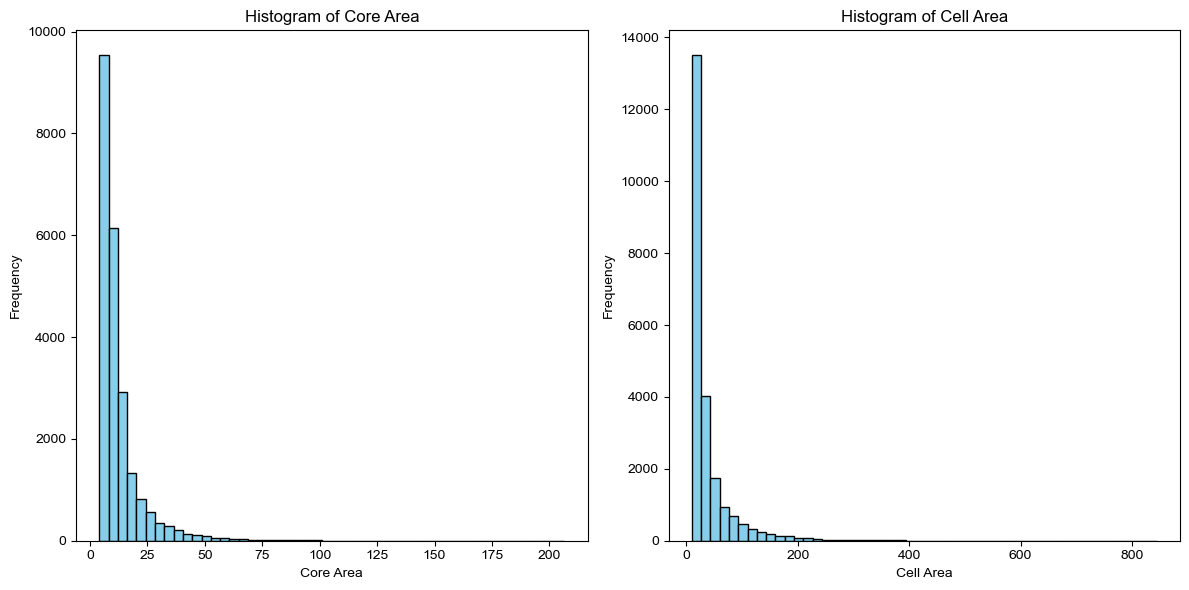

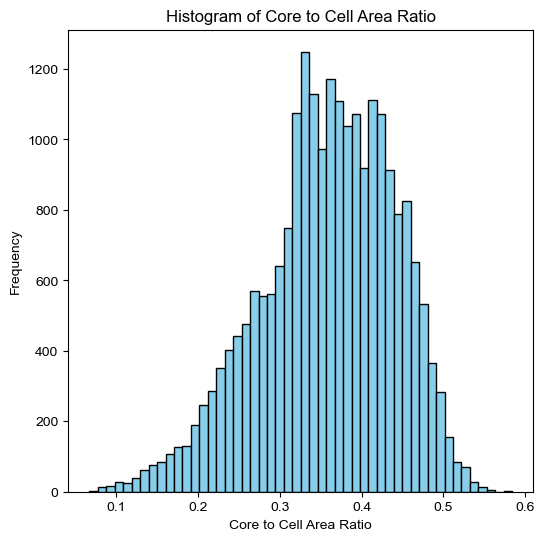

| Statistics       |       Value |
|:-----------------|------------:|
| Core area median |   9         |
| Core area min    |   4         |
| Core area max    | 206.5       |
| Core area std    |  10.6265    |
| Cell area mean   |  38.8956    |
| Cell area median |  23         |
| Cell area min    |   9.5       |
| Cell area max    | 844.75      |
| Cell area std    |  45.2508    |
| Ratio mean       |   0.358447  |
| Ratio median     |   0.365079  |
| Ratio min        |   0.0669145 |
| Ratio max        |   0.58427   |
| Ratio std        |   0.0817094 |


In [37]:
# Extract core and cell areas
core_area = stats['core_area']
cell_area = stats['cell_area']

# Compute basic statistics for core_area
core_area_mean = core_area.mean().item()
core_area_median = np.nanmedian(core_area)
core_area_min = np.nanmin(core_area)
core_area_max = np.nanmax(core_area)
core_area_std = np.nanstd(core_area)

# Compute basic statistics for cell_area
cell_area_mean = cell_area.mean().item()
cell_area_median = np.nanmedian(cell_area)
cell_area_min = np.nanmin(cell_area)
cell_area_max = np.nanmax(cell_area)
cell_area_std = np.nanstd(cell_area)

# Create histograms for core_area and cell_area
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(core_area.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Core Area')
plt.xlabel('Core Area')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(cell_area.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Cell Area')
plt.xlabel('Cell Area')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compute ratio of core_area to cell_area and visualize its distribution
ratio = core_area / cell_area
ratio_mean = ratio.mean().item()
ratio_median = np.nanmedian(ratio)
ratio_min = np.nanmin(ratio)
ratio_max = np.nanmax(ratio)
ratio_std = np.nanstd(ratio)

plt.figure(figsize=(6, 6))
plt.hist(ratio.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Core to Cell Area Ratio')
plt.xlabel('Core to Cell Area Ratio')
plt.ylabel('Frequency')
plt.show()

# Prepare the data as a list of lists
data = [
    ["Core area median", core_area_median],
    ["Core area min", core_area_min],
    ["Core area max", core_area_max],
    ["Core area std", core_area_std],
    ["Cell area mean", cell_area_mean],
    ["Cell area median", cell_area_median],
    ["Cell area min", cell_area_min],
    ["Cell area max", cell_area_max],
    ["Cell area std", cell_area_std],
    ["Ratio mean", ratio_mean],
    ["Ratio median", ratio_median],
    ["Ratio min", ratio_min],
    ["Ratio max", ratio_max],
    ["Ratio std", ratio_std]
]

# Print the table
print(tabulate(data, headers=["Statistics", "Value"], tablefmt="pipe"))


Notes: 

Core Area: The mean core area is approximately 12.23, but the distribution is skewed towards larger values (the median is 9, less than the mean), as can be seen in the histogram. The smallest core area is 4, and the largest is 206.5. The standard deviation is 10.63, indicating a fair amount of variability in the core areas of the convective cells.

Cell Area: The mean cell area is approximately 38.90, and the distribution is also skewed towards larger values (the median is 23). The smallest cell area is 9.5, and the largest is 844.75. The standard deviation is 45.25, suggesting a high degree of variability in the cell areas.

Ratio of Core Area to Cell Area: On average, the core area makes up about 36% of the cell area. This ratio has a fairly tight distribution (standard deviation is 0.08), with most values falling between 7% and 58%.

These results provide a general understanding of the size and structure of the convective cells in the dataset. They show that there is a wide range of cell and core sizes, with the core typically occupying about a third of the total cell area.

## 1. How does the core area change over the lifespan of a convective cell?

The maximum lifetime is 5.6644


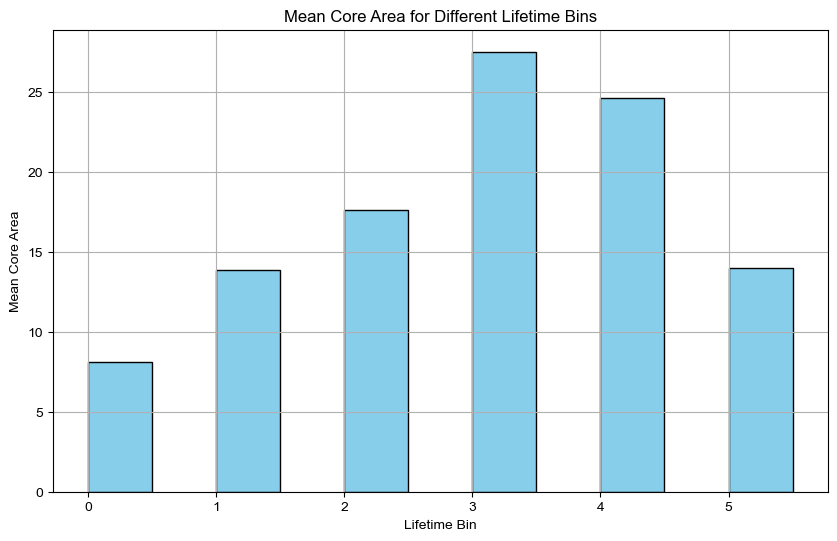

In [38]:
# Find the maximum lifetime
print(f'The maximum lifetime is {np.nanmax(lifetime.values)}')

# 
idx_long = np.where(lifetime > 0)[0]
lifetime_long = lifetime.isel(tracks=idx_long)          # Lifetime of cells greater than zero
core_area_long = core_area.isel(tracks=idx_long)        # Core area of the cells greater than zero

# Plot the core_area for each track over time
# Compute the mean core area across time for each track with lifetime > 0
core_area_mean_long = np.nanmean(core_area_long.values, axis=1)
# Bin lifetime into specified bins
bins = np.array([0, 1, 2, 3, 4, 5, 6])  # define the bins
lifetime_binned = np.digitize(lifetime_long.values, bins)  # bin the lifetime

# Calculate the mean core area for each bin
core_area_bin_means = []
for i in range(1, len(bins)):
    idx_bin = np.where(lifetime_binned == i)[0]
    core_area_bin_mean = np.nanmean(core_area_mean_long[idx_bin])
    core_area_bin_means.append(core_area_bin_mean)

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], core_area_bin_means, width=0.5, color='skyblue', edgecolor='black', align='edge')
plt.title('Mean Core Area for Different Lifetime Bins')
plt.xlabel('Lifetime Bin')
plt.ylabel('Mean Core Area')
plt.xticks(bins[:-1], labels=[f'{bins[i]}' for i in range(len(bins)-1)])
plt.grid(True)
plt.show()



In [39]:
idx_long_1 = np.where((lifetime > 0) & (lifetime < 1))[0]
lifetime_1 = lifetime.isel(tracks=idx_long_1)          # Lifetime of cells greater than zero
core_area_1 = core_area.isel(tracks=idx_long_1)        # Core area of the cells greater than zero
cell_area_1 = cell_area.isel(tracks=idx_long_1)

idx_long_2 = np.where((lifetime > 1) & (lifetime < 2))[0]
lifetime_2 = lifetime.isel(tracks=idx_long_2)          # Lifetime of cells greater than zero
core_area_2 = core_area.isel(tracks=idx_long_2)        # Core area of the cells greater than zero
cell_area_2 = cell_area.isel(tracks=idx_long_2)

idx_long_3 = np.where((lifetime > 2) & (lifetime < 3))[0]
lifetime_3 = lifetime.isel(tracks=idx_long_3)          # Lifetime of cells greater than zero
core_area_3 = core_area.isel(tracks=idx_long_3)        # Core area of the cells greater than zero
cell_area_3 = cell_area.isel(tracks=idx_long_3)

idx_long_4 = np.where((lifetime > 3) & (lifetime < 4))[0]
lifetime_4 = lifetime.isel(tracks=idx_long_4)          # Lifetime of cells greater than zero
core_area_4 = core_area.isel(tracks=idx_long_4)        # Core area of the cells greater than zero
cell_area_4 = cell_area.isel(tracks=idx_long_4)

idx_long_5 = np.where((lifetime > 4) & (lifetime < 5))[0]
lifetime_5 = lifetime.isel(tracks=idx_long_5)          # Lifetime of cells greater than zero
core_area_5 = core_area.isel(tracks=idx_long_5)        # Core area of the cells greater than zero
cell_area_5 = cell_area.isel(tracks=idx_long_5)

idx_long_6 = np.where((lifetime > 5) & (lifetime < 6))[0]
lifetime_6 = lifetime.isel(tracks=idx_long_6)          # Lifetime of cells greater than zero
core_area_6 = core_area.isel(tracks=idx_long_6)        # Core area of the cells greater than zero
cell_area_6 = cell_area.isel(tracks=idx_long_6)

In [40]:
len(core_area.values), len(lifetime.values)

(3606, 3606)

In [61]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname,
                   legend_loc='lower right', legend_labels=None):
    mpl.rcParams['font.family'] = 'Arial'
    g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

    lcolors = {'obs':'steelblue', 'model':'darkorange'}
    cmap = copy.copy(mpl.cm.get_cmap('Blues'))
    cmap = truncate_colormap(cmap, 0.1, 1)
    sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap=cmap, alpha=0.9, ax=g.ax_joint)
    sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
    sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
    sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
    sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
    sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
    legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
                       mpl.lines.Line2D([0], [0], color=lcolors['model'])]
    leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
                            loc=legend_loc, facecolor='w', prop={'family':'Arial', 'size':18})
    g.ax_joint.text(0.95, 0.95, annotate_text, ha='right', va='center', transform=g.ax_joint.transAxes)
    g.ax_joint.add_artist(leg)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    g.ax_marg_x.set_ylabel('')
    g.ax_marg_y.set_xlabel('')
    # g.savefig(figname, dpi=300, facecolor='w')
    return g

C:\Users\omitu\AppData\Local\Temp\ipykernel_4000\1480409035.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap('Blues'))


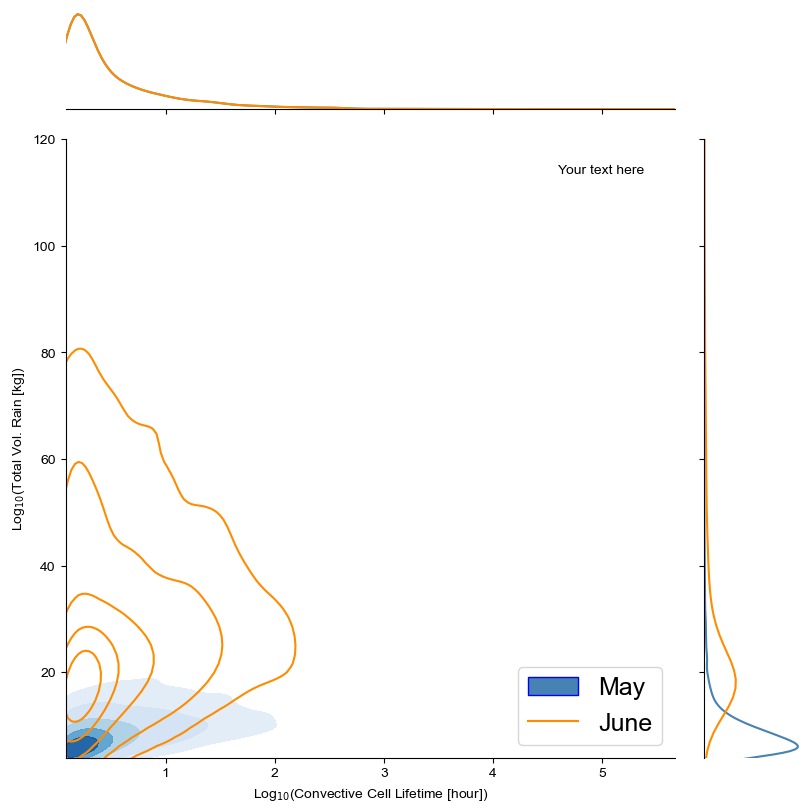

In [69]:


# Calculate the mean along the 'times' dimension for 'core_area' and 'cell_area'
mean_core_area = stats['core_area'].mean(dim='times')
mean_cell_area = stats['cell_area'].mean(dim='times')

# Apply the log10 transformation
x_obs, y_obs = (lifetime.values), (mean_core_area.values)
x_m1, y_m1 = (lifetime.values), (mean_cell_area.values)

# Calculate the minimum and maximum values of x and y
x_min, x_max = np.min(x_obs), np.max(x_obs)
y_min, y_max = np.min([np.min(y_obs), np.min(y_m1)]), np.max([np.max(y_obs), np.max(y_m1)])

# Update the x and y limits
xlim = (x_min, x_max)
ylim = (y_min, 120)
legend_labels = ['May', 'June', 'July']
# Update xlabel and ylabel
xlabel = 'Log$_{10}$(Convective Cell Lifetime [hour])'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = 'Your text here'
figname = 'Your figure name here'
levels = [0.1,0.2,0.4,0.6,0.8,1]

# Run the plot function
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)
plt.show()


In [67]:
max(mean_core_area.values)

62.26829

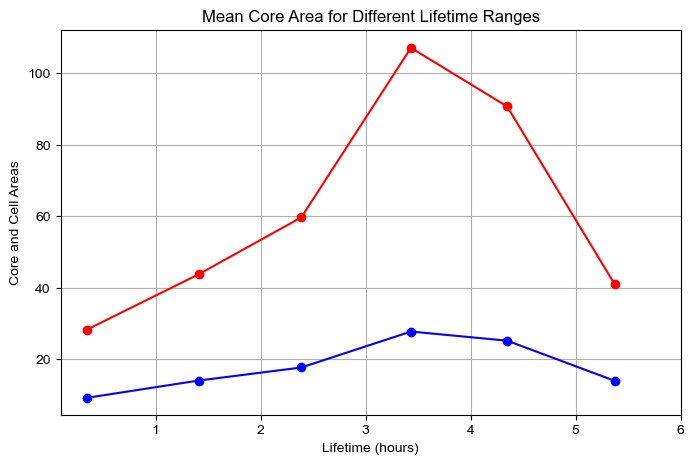

In [44]:
# Calculate mean core area for each lifetime range
mean_core_area_1 = np.nanmean(core_area_1)
mean_core_area_2 = np.nanmean(core_area_2)
mean_core_area_3 = np.nanmean(core_area_3)
mean_core_area_4 = np.nanmean(core_area_4)
mean_core_area_5 = np.nanmean(core_area_5)
mean_core_area_6 = np.nanmean(core_area_6)

mean_cell_area_1 = np.nanmean(cell_area_1)
mean_cell_area_2 = np.nanmean(cell_area_2)
mean_cell_area_3 = np.nanmean(cell_area_3)
mean_cell_area_4 = np.nanmean(cell_area_4)
mean_cell_area_5 = np.nanmean(cell_area_5)
mean_cell_area_6 = np.nanmean(cell_area_6)

mean_lifetime_1 = np.nanmean(lifetime_1)
mean_lifetime_2 = np.nanmean(lifetime_2)
mean_lifetime_3 = np.nanmean(lifetime_3)
mean_lifetime_4 = np.nanmean(lifetime_4)
mean_lifetime_5 = np.nanmean(lifetime_5)
mean_lifetime_6 = np.nanmean(lifetime_6)

# Create line chart for each lifetime range
plt.figure(figsize=(8, 5))
plt.plot([mean_lifetime_1, mean_lifetime_2, mean_lifetime_3, mean_lifetime_4, mean_lifetime_5, mean_lifetime_6], 
         [mean_core_area_1, mean_core_area_2, mean_core_area_3, mean_core_area_4, mean_core_area_5, mean_core_area_6], 
         marker='o', linestyle='-', color='blue', label = "Mean Core Area")
plt.plot([mean_lifetime_1, mean_lifetime_2, mean_lifetime_3, mean_lifetime_4, mean_lifetime_5, mean_lifetime_6], 
         [mean_cell_area_1, mean_cell_area_2, mean_cell_area_3, mean_cell_area_4, mean_cell_area_5, mean_cell_area_6], 
         marker='o', linestyle='-', color='red', label = "Mean Cell Area")
plt.title('Mean Core Area for Different Lifetime Ranges')
plt.xlabel('Lifetime (hours)')
plt.ylabel('Core and Cell Areas')
plt.xticks([1, 2, 3, 4, 5, 6])
plt.grid(True)
plt.show()


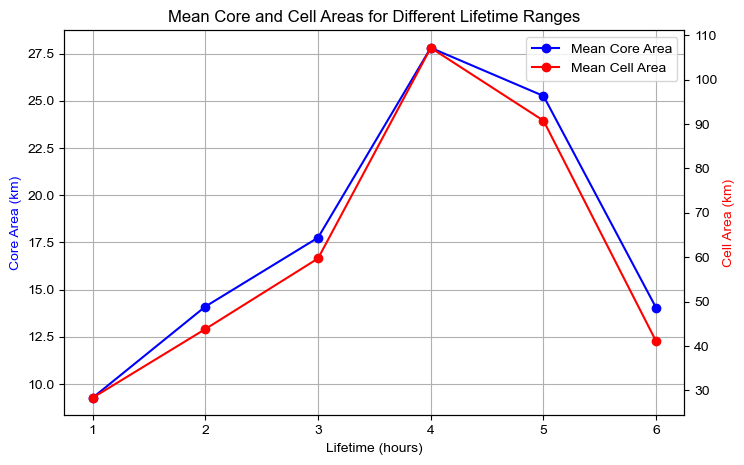

In [45]:
# Calculate mean cell area for each lifetime range
mean_cell_area_1 = np.nanmean(cell_area.isel(tracks=idx_long_1).values)
mean_cell_area_2 = np.nanmean(cell_area.isel(tracks=idx_long_2).values)
mean_cell_area_3 = np.nanmean(cell_area.isel(tracks=idx_long_3).values)
mean_cell_area_4 = np.nanmean(cell_area.isel(tracks=idx_long_4).values)
mean_cell_area_5 = np.nanmean(cell_area.isel(tracks=idx_long_5).values)
mean_cell_area_6 = np.nanmean(cell_area.isel(tracks=idx_long_6).values)

# Create figure and axis for left y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot mean core area on left y-axis
ax1.plot([1, 2, 3, 4, 5, 6], 
         [mean_core_area_1, mean_core_area_2, mean_core_area_3, mean_core_area_4, mean_core_area_5, mean_core_area_6], 
         marker='o', linestyle='-', color='blue', label='Mean Core Area')

# Create another axis for right y-axis, sharing the same x-axis
ax2 = ax1.twinx()

# Plot mean cell area on right y-axis
ax2.plot([1, 2, 3, 4, 5, 6], 
         [mean_cell_area_1, mean_cell_area_2, mean_cell_area_3, mean_cell_area_4, mean_cell_area_5, mean_cell_area_6], 
         marker='o', linestyle='-', color='red', label='Mean Cell Area')

# Set labels and title
ax1.set_xlabel('Lifetime (hours)')
ax1.set_ylabel('Core Area (km)', color='blue')
ax2.set_ylabel('Cell Area (km)', color='red')
plt.title('Mean Core and Cell Areas for Different Lifetime Ranges')
plt.xticks([1, 2, 3, 4, 5, 6])

# Display grid and legend
ax1.grid(True)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()
